<a href="https://colab.research.google.com/github/CGClifford/MADS_Capstone_2/blob/main/SIADS_696_MII_Source_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIADS MII - Music Prediction
_cgcliff, mcpark, sebcapp_

**Overview**

The goal of this project is to learn what makes a song popular through supervised and unsupervised learning methods. Specifically, we would like to draw insights into whether attributes of a song can predict its popularity. In this context, we measure popularity based on open source data around song charts (e.g. Billboard 100, Spotify streams) and define features based on the song’s metadata (e.g. key, genre, artist, location, BPM, lyrics).

The analysis and learning techniques will focus on a narrower scope of music for simplicity and academic purposes. We will focus on the genres: Country and Hip-Hop given these 2 utilize lyrics the most, which will be good for NLP processing.

**Data Sources**
* [Million Song Data Subset](https://drive.google.com/drive/folders/16aK6UaVX1fec_wfW79bB1G7rBguc4Psn?usp=sharing) - Random selection of 10K songs from the [Million Song Dataset](http://millionsongdataset.com/) due to memory constraints
* [Song Lyrics](http://millionsongdataset.com/musixmatch/) - bag of words for the Million Song Dataset
* [Billboard chars data](https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs?resource=download) - The Billboard Hot 100 is the music industry standard record chart in the United States for songs, published weekly by Billboard magazine. Chart rankings are based on sales, radio play, and online streaming in the United States.
* [Spotify top streams](https://www.kaggle.com/datasets/iamsumat/spotify-top-2000s-mega-dataset) - audio statistics of the top 2000 tracks on Spotify

---
## Data Prep
_mcpark_

**How to load dataset from Drive for analysis**

1. Navigate to cell titled "Start Here" and run all cells to:
  * Mount the Colab to your drive
  * Load in the CSVs that have been prepared in the previous cells
  * Output analysis DataFrames for processing

Running the code to generate the million song subset CSV can take hours so do not run those cells.

In [ ]:
#@markdown Import Modules
import pandas as pd
import numpy as np
import h5py
import glob
import os

Since our million song data comes in h5 format, data is clustered in a hierarchical manner. Therefore, we will iterate through each folder/song file to generate a single dataframe for anaysis

[Fields associated with each track](http://millionsongdataset.com/pages/example-track-description/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# example look at song data
example_song_path = '/content/drive/MyDrive/SIADS M2 Project/MillionSongSubset/A/F/H/TRAFHBH128F42970EF.h5'

# navigate into the folders that contain info we care about for a given song and store in df format
sample_audio_df = pd.DataFrame(np.array(h5py.File(example_song_path)['analysis']['songs']))
sample_metadata_df = pd.DataFrame(np.array(h5py.File(example_song_path)['metadata']['songs']))

# concatenate to make 1 single row (with artist & song id as primary key) containing a song's metadata
pd.concat([sample_metadata_df,sample_audio_df], axis=1).set_index(['artist_id','song_id'])

,,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,...,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_id
artist_id,song_id,,,,,,,,,,,,,,,,,,,,,
b'AR0BV7E1187FB386C1',b'SOLOEUX12A58A7C81F',b'',40247,0.632008,0.144685,NaN,"b'Hollywood, CA'",NaN,b'0c361ea5-98c6-4947-900b-201833f2dd84',b'Lee Ritenour',5194,...,10,0.353,-14.199,1,0.248,274.419,82.733,4,0.168,b'TRAFHBH128F42970EF'


In [ ]:
test = pd.DataFrame(np.array(h5py.File(example_song_path)['metadata']['songs']))

for column in test.columns:
  if test[column].dtype == 'object':
    test[column] = test[column].str.decode('UTF-8')

test

,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,,40247,0.632008,0.144685,AR0BV7E1187FB386C1,NaN,"Hollywood, CA",NaN,0c361ea5-98c6-4947-900b-201833f2dd84,Lee Ritenour,5194,,0,0,Rit/2,111304,0.380899,SOLOEUX12A58A7C81F,Keep It Alive,1150791


In [ ]:
pd.concat([sample_metadata_df,sample_audio_df], axis=1).set_index(['artist_id','song_id']).columns

Index(['analyzer_version', 'artist_7digitalid', 'artist_familiarity',
       'artist_hotttnesss', 'artist_latitude', 'artist_location',
       'artist_longitude', 'artist_mbid', 'artist_name', 'artist_playmeid',
       'genre', 'idx_artist_terms', 'idx_similar_artists', 'release',
       'release_7digitalid', 'song_hotttnesss', 'title', 'track_7digitalid',
       'analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
     

In [ ]:
# file name of a given path
os.path.basename(example_song_path).split('/')[-1]

'TRAFHBH128F42970EF.h5'

### Create DF from h5 files (**skip this step**)

In [ ]:
# initialize a DF for million song dataset data
million_song_df = pd.DataFrame()

# define the features we care about for efficient processing
audio_columns = 'danceability', 'duration','energy', 'key', 'key_confidence', 'loudness', 'mode','mode_confidence','tempo'
metadata_columns = 'artist_id', 'artist_location', 'artist_name', 'artist_hotttnesss', 'genre', 'release', 'song_hotttnesss', 'song_id', 'title', 'artist_7digitalid', 'track_7digitalid','release_7digitalid','idx_similar_artists'

# iterate through our dataset and append song data to our million song df for analysis
for f in glob.glob('/content/drive/MyDrive/SIADS M2 Project/MillionSongSubset/*'):
  for letter in glob.glob(f+'/*'):
    for sub_letter in glob.glob(letter+'/*'):
      for song in glob.glob(sub_letter+'/*'):
        audio_df = pd.DataFrame(np.array(h5py.File(song)['analysis']['songs'][audio_columns]))
        metadata_df = pd.DataFrame(np.array(h5py.File(song)['metadata']['songs'][metadata_columns]))
        # convert bytes to string in both df types
        for column in audio_df.columns:
          if audio_df[column].dtype == 'object':
            audio_df[column] = audio_df[column].str.decode('UTF-8')
        for column in metadata_df.columns:
          if metadata_df[column].dtype == 'object':
            metadata_df[column] = metadata_df[column].str.decode('UTF-8')
        # use artist terms field and aggregate values to define which genres apply to the song
        metadata_df['genre_tags'] = pd.Series(''.join(
            str(x)[2:-1]+', ' for x in list(h5py.File(song)['metadata']['artist_terms'])))
        # add the file name as a column to use as a join key for bag of words dataset
        metadata_df['file_name'] = os.path.basename(song).split('/')[-1]
        song_df = pd.concat([metadata_df,audio_df], axis=1).set_index('file_name')
        million_song_df = million_song_df.append(song_df)

Since the df generation takes X+ hours to run, we will save the output as a CSV to read in to save time while we work on the project

In [ ]:
from google.colab import drive

path = '/content/drive/Shareddrives/SIADS M2 Project/millionsong_subset.csv'

# save df to Drive as a CSV
with open(path, 'w', encoding = 'utf-8-sig') as f:
  million_song_df.to_csv(f)

## Merge and clean DFs to get features and labels for our song data

In [ ]:
# Import Modules
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')
song_data = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/millionsong_subset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@markdown Here we can use billboard chart data and/or spotify top songs for our training labels - whichever we decide to use we can join the DFs on song & artist
charts = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/charts.csv')
spotify = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/Spotify-2000.csv')

In [ ]:
song_data['song_hotttnesss'].describe()

count    5648.000000
mean        0.342822
std         0.247220
min         0.000000
25%         0.000000
50%         0.360371
75%         0.537504
max         1.000000
Name: song_hotttnesss, dtype: float64

In [ ]:
charts = charts[['song','artist','peak-rank','weeks-on-board']].groupby(['artist','song']).agg({'peak-rank':'min','weeks-on-board':'max'}).reset_index()

In [ ]:
(((101 - charts['peak-rank']) * charts['weeks-on-board'])/1000).describe()

count    29681.000000
mean         0.784239
std          0.830542
min          0.001000
25%          0.120000
50%          0.520000
75%          1.240000
max          9.000000
dtype: float64

In [ ]:
# new popularity score to transform our popularity score in song_data from 0-10

charts['boosted_score'] = ((101 - charts['peak-rank']) * charts['weeks-on-board'])/1000
charts.sort_values(by='boosted_score', ascending=False).head(10)

,artist,song,peak-rank,weeks-on-board,boosted_score,cleaned_artist,cleaned_song
27367,The Weeknd,Blinding Lights,1,90,9.000,theweeknd,blindinglights
11281,Imagine Dragons,Radioactive,3,87,8.526,imaginedragons,radioactive
12119,Jason Mraz,I'm Yours,6,76,7.220,jasonmraz,imyours
15133,LeAnn Rimes,How Do I Live,2,69,6.831,leannrimes,howdoilive
14933,LMFAO Featuring Lauren Bennett & GoonRock,Party Rock Anthem,1,68,6.800,lmfaofeaturinglaurenbennettgoonrock,partyrockanthem
18958,OneRepublic,Counting Stars,2,68,6.732,onerepublic,countingstars
405,AWOLNATION,Sail,17,79,6.636,awolnation,sail
510,Adele,Rolling In The Deep,1,65,6.500,adele,rollinginthedeep
12514,Jewel,Foolish Games/You Were Meant For Me,2,65,6.435,jewel,foolishgamesyouweremeantforme
20083,Post Malone,Circles,1,61,6.100,postmalone,circles


In [ ]:
# Function to clean up columns for merging by removing all special characters/spaces and lower casing

def column_cleanup(series):
  new_list = []
  for string in series:
    new_string = ''.join(x for x in str(string) if x.isalnum()).lower()
    new_list.append(new_string)
  return new_list

song_data['cleaned_artist_name'] = pd.Series(column_cleanup(song_data['artist_name']))
song_data['cleaned_title'] = pd.Series(column_cleanup(song_data['title']))
charts['cleaned_artist'] = pd.Series(column_cleanup(charts['artist']))
charts['cleaned_song'] = pd.Series(column_cleanup(charts['song']))


# Merge DFs using inner join on matching columns that were cleaned
charts_analysis_data = pd.merge(
    song_data, charts, how='left', left_on=['cleaned_artist_name','cleaned_title'], right_on=['cleaned_artist','cleaned_song']
    ).drop(columns=['artist','song']).rename(columns={'peak-rank':'charts_peak_rank','weeks-on-board':'chart_weeks'})


In [ ]:
charts_analysis_data['boosted_score'] = charts_analysis_data['boosted_score'].fillna(0) + charts_analysis_data['song_hotttnesss']

In [ ]:
charts_analysis_data['boosted_score'].describe()

count    5648.000000
mean        0.362064
std         0.333541
min         0.000000
25%         0.000000
50%         0.360371
75%         0.541409
max         5.600520
Name: boosted_score, dtype: float64

In [ ]:
analysis_data = charts_analysis_data[(charts_analysis_data.genre_tags.notnull()) & (charts_analysis_data.boosted_score.notnull())].drop(columns=[
    'genre','key_confidence','mode_confidence','chart_weeks','charts_peak_rank','cleaned_artist', 'cleaned_song','cleaned_artist_name', 'cleaned_title'])
analysis_data.describe()

,artist_hotttnesss,song_hotttnesss,artist_7digitalid,track_7digitalid,release_7digitalid,idx_similar_artists,danceability,duration,energy,key,loudness,mode,tempo,boosted_score
count,5645.000000,5645.000000,5645.000000,5.645000e+03,5645.000000,5645.0,5645.0,5645.00000,5645.0,5645.000000,5645.000000,5645.000000,5645.000000,5645.000000
mean,0.407070,0.343004,100137.309655,3.925571e+06,353108.515323,0.0,0.0,240.34810,0.0,5.261293,-10.015481,0.693888,123.449816,0.362256
std,0.127464,0.247159,133592.237893,2.631834e+06,237073.267916,0.0,0.0,110.92467,0.0,3.535023,5.167929,0.460917,34.895870,0.333526
min,0.000000,0.000000,-1.000000,8.450000e+02,63.000000,0.0,0.0,7.13098,0.0,0.000000,-41.691000,0.000000,0.000000,0.000000
25%,0.345718,0.000000,9400.000000,1.572055e+06,148743.000000,0.0,0.0,181.13261,0.0,2.000000,-12.647000,0.000000,97.045000,0.000000
50%,0.396800,0.360371,35339.000000,3.505052e+06,307980.000000,0.0,0.0,226.92526,0.0,5.000000,-8.912000,1.000000,120.138000,0.360371
75%,0.468247,0.537504,157532.000000,6.118183e+06,553081.000000,0.0,0.0,278.22975,0.0,8.000000,-6.268000,1.000000,145.115000,0.541493
max,1.082503,1.000000,777640.000000,9.087795e+06,823358.000000,0.0,0.0,1815.22240,0.0,11.000000,0.566000,1.000000,262.828000,5.600520


In [ ]:
# generate DFs based on genre

hip_hop_df = analysis_data[analysis_data['genre_tags'].str.contains('hip hop')]
country_df = analysis_data[analysis_data['genre_tags'].str.contains('country')]
rock_df = analysis_data[analysis_data['genre_tags'].str.contains('rock')]
pop_df = analysis_data[analysis_data['genre_tags'].str.contains('pop')]
jazz_df = analysis_data[analysis_data['genre_tags'].str.contains('jazz')]
electronic_df = analysis_data[analysis_data['genre_tags'].str.contains('electronic')]

In [ ]:
# save df to Drive as a CSV
with open('/content/drive/Shareddrives/SIADS M2 Project/analysis_data.csv', 'w', encoding = 'utf-8-sig') as f:
  analysis_data.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/country_df.csv', 'w', encoding = 'utf-8-sig') as f:
  country_df.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/hip_hop_df.csv', 'w', encoding = 'utf-8-sig') as f:
  hip_hop_df.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/rock_df.csv', 'w', encoding = 'utf-8-sig') as f:
  rock_df.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/pop_df.csv', 'w', encoding = 'utf-8-sig') as f:
  pop_df.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/jazz_df.csv', 'w', encoding = 'utf-8-sig') as f:
  jazz_df.to_csv(f)
with open('/content/drive/Shareddrives/SIADS M2 Project/electronic_df.csv', 'w', encoding = 'utf-8-sig') as f:
  electronic_df.to_csv(f)

## Start Here - Load DFs from cleaned CSV files

In [33]:
# Import Modules
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')
analysis_data = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/analysis_data.csv')
country_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/country_df.csv')
hip_hop_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/hip_hop_df.csv')
rock_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/rock_df.csv')
pop_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/pop_df.csv')
jazz_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/jazz_df.csv')
electronic_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/electronic_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
analysis_data['artist_location'].value_counts()[:10]

Los Angeles, CA       94
New York, NY          87
London, England       84
California - LA       48
Chicago, IL           46
Brooklyn, NY          37
Kingston, Jamaica     36
NY - New York City    34
Texas                 33
United States         33
Name: artist_location, dtype: int64

In [35]:
hip_hop_df.head(2)

,Unnamed: 0,file_name,artist_id,artist_location,artist_name,artist_hotttnesss,release,song_hotttnesss,song_id,title,...,idx_similar_artists,genre_tags,danceability,duration,energy,key,loudness,mode,tempo,boosted_score
0,0,TRBGAWQ128F9305F25.h5,ARYXOV81187B99831D,NaN,Seventh Day Slumber,0.509243,Take Everything,0.635630,SOPBEBP12AB0181527,Famous One,...,0,"christian rock, christian alternative rock, ch...",0.0,265.82159,0.0,5,-5.742,1,118.620,0.635630
1,9,TRBGGBF128F425E4D1.h5,AR7IYVY1187B9A2648,"Tromso, Norway",bel canto,0.368252,Magic Box,0.345802,SOBEHXG12A8C138D22,Rumour (Abstract Hip Hop Mix),...,0,"trip hop, downtempo, electronic, alternative d...",0.0,78.49751,0.0,7,-17.795,1,106.936,0.345802


In [36]:
# how many songs did we boost?
len(analysis_data[analysis_data['song_hotttnesss'] != analysis_data['boosted_score']])

95

## Output for learning tasks

Millionsong subset data (10K songs with features for each song) with "song hotness scores", combined with billboard charts data to "boost" hotness ratings. DFs are also generated for genre types where song's "genre tags" included the given genre.

Output DFs for further processing:

* **country_df** - main dataframe containing all country song data with song features and "boosted_score" as training label
* **hip_hop_df** - main dataframe containing all hip hop song data with song features and "boosted_score" as training label

Additional data for exploration if needed:

* **analysis_data** - all songs and data that have a "hotness score" / "boosted_score" added as popularity proxy metric
* **rock_df** - rock songs data that have a "hotness score" / "boosted_score" added as popularity proxy metric
* **pop_df** - pop songs data that have a "hotness score" / "boosted_score" added as popularity proxy metric
* **jazz_df** - jazz songs data that have a "hotness score" / "boosted_score" added as popularity proxy metric
* **electronic_df** - electronic songs data that have a "hotness score" / "boosted_score" added as popularity proxy metric


In [37]:
analysis_data.describe()

,Unnamed: 0,artist_hotttnesss,song_hotttnesss,artist_7digitalid,track_7digitalid,release_7digitalid,idx_similar_artists,danceability,duration,energy,key,loudness,mode,tempo,boosted_score
count,5645.000000,5645.000000,5645.000000,5645.000000,5.645000e+03,5645.000000,5645.0,5645.0,5645.00000,5645.0,5645.000000,5645.000000,5645.000000,5645.000000,5645.000000
mean,5063.132152,0.407070,0.343004,100137.309655,3.925571e+06,353108.515323,0.0,0.0,240.34810,0.0,5.261293,-10.015481,0.693888,123.449816,0.362256
std,2875.752310,0.127464,0.247159,133592.237893,2.631834e+06,237073.267916,0.0,0.0,110.92467,0.0,3.535023,5.167929,0.460917,34.895870,0.333526
min,0.000000,0.000000,0.000000,-1.000000,8.450000e+02,63.000000,0.0,0.0,7.13098,0.0,0.000000,-41.691000,0.000000,0.000000,0.000000
25%,2602.000000,0.345718,0.000000,9400.000000,1.572055e+06,148743.000000,0.0,0.0,181.13261,0.0,2.000000,-12.647000,0.000000,97.045000,0.000000
50%,5076.000000,0.396800,0.360371,35339.000000,3.505052e+06,307980.000000,0.0,0.0,226.92526,0.0,5.000000,-8.912000,1.000000,120.138000,0.360371
75%,7582.000000,0.468247,0.537504,157532.000000,6.118183e+06,553081.000000,0.0,0.0,278.22975,0.0,8.000000,-6.268000,1.000000,145.115000,0.541493
max,9998.000000,1.082503,1.000000,777640.000000,9.087795e+06,823358.000000,0.0,0.0,1815.22240,0.0,11.000000,0.566000,1.000000,262.828000,5.600520


country labels:  [0 0 1 ... 0 0 0]
hip hop labels:  [0 0 1 ... 0 0 0]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.50
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.50


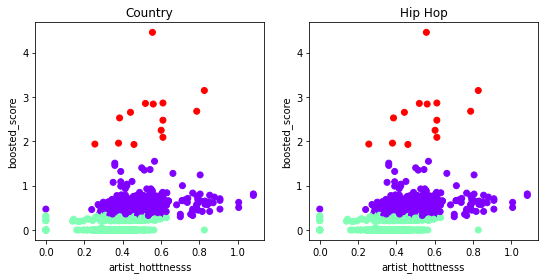

country labels:  [2 2 1 ... 0 0 2]
hip hop labels:  [2 2 0 ... 1 1 2]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.66
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.66


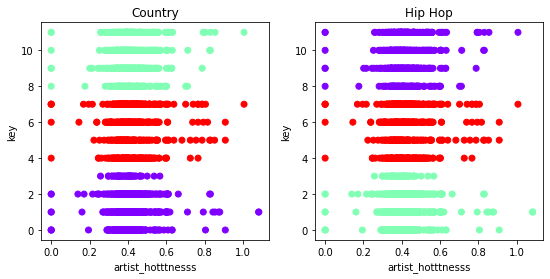

country labels:  [0 1 0 ... 1 2 0]
hip hop labels:  [0 2 0 ... 2 1 0]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.58
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.58


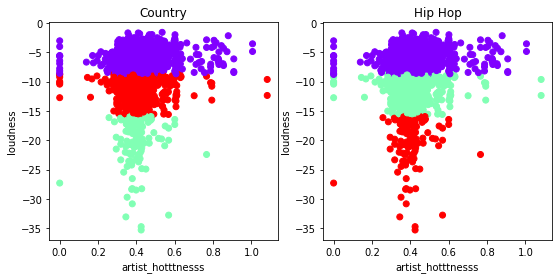

country labels:  [0 0 0 ... 0 1 0]
hip hop labels:  [0 0 0 ... 0 1 0]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.54
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.54


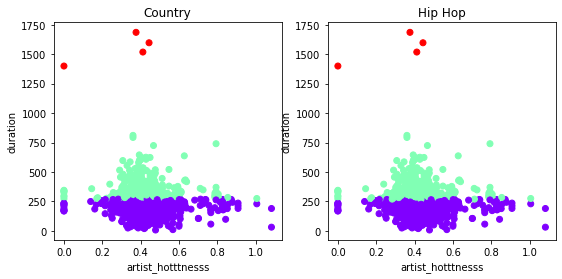

country labels:  [2 0 0 ... 1 0 2]
hip hop labels:  [0 1 1 ... 2 1 0]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.53
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.53


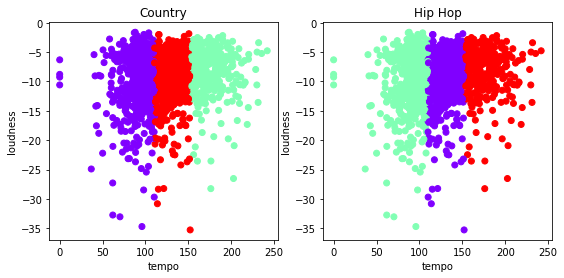

country labels:  [0 1 1 ... 2 1 0]
hip hop labels:  [2 1 1 ... 0 1 2]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.54
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.54


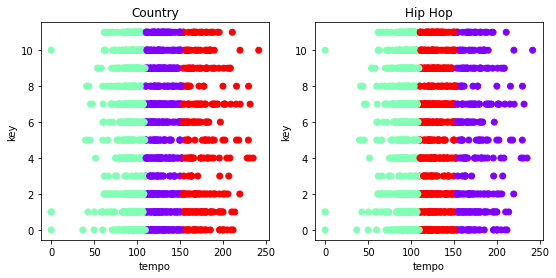

country labels:  [1 1 1 ... 1 0 1]
hip hop labels:  [1 1 1 ... 1 0 1]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.44
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.44


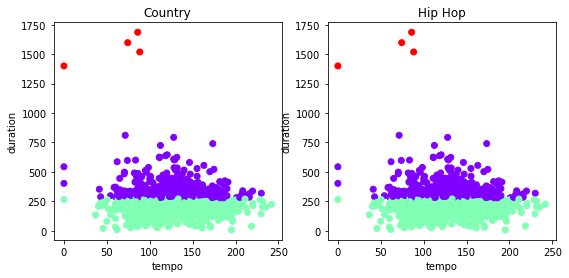

country labels:  [2 0 1 ... 0 2 2]
hip hop labels:  [1 2 0 ... 2 1 1]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.41
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.41


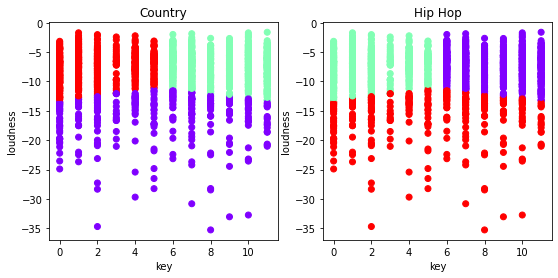

country labels:  [0 0 0 ... 0 1 0]
hip hop labels:  [1 1 1 ... 1 0 1]
Country Silhouette Coefficient for the Analysis Dataset Clusters: 0.54
Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: 0.53


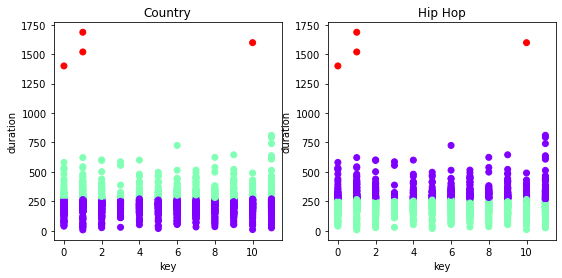

In [38]:
#@markdown USL K Means Clustering of features we are interested in

import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

combinations = [['artist_hotttnesss','boosted_score'],
                ['artist_hotttnesss','key'],
                ['artist_hotttnesss','loudness'],
                ['artist_hotttnesss','duration'],
                ['tempo','loudness'],
                ['tempo','key'],
                ['tempo','duration'],
                ['key','loudness'],
                ['key','duration']]

for feature_combos in combinations:
  
  country_x = hip_hop_df[feature_combos]
  hip_hop_x = hip_hop_df[feature_combos]
  
  # Creating the KMeans object and fitting it
  country_kmeans = KMeans(n_clusters=3)
  country_kmeans.fit(country_x)
  hiphop_kmeans = KMeans(n_clusters=3)
  hiphop_kmeans.fit(hip_hop_x)

  # Predicting the cluster labels
  country_labels = country_kmeans.predict(country_x)
  print('country labels: ',country_labels)
  hiphop_labels = hiphop_kmeans.predict(hip_hop_x)
  print('hip hop labels: ',hiphop_labels)

  # Finding the final centroids
  country_centroids = country_kmeans.cluster_centers_
  hiphop_centroids = hiphop_kmeans.cluster_centers_

  # Evaluating the quality of clusters
  country_s = metrics.silhouette_score(country_x, country_labels, metric='euclidean')
  hiphop_s = metrics.silhouette_score(hip_hop_x, hiphop_labels, metric='euclidean')
  print(f'Country Silhouette Coefficient for the Analysis Dataset Clusters: {country_s:.2f}')
  print(f'Hip Hop Silhouette Coefficient for the Analysis Dataset Clusters: {hiphop_s:.2f}')

  # plotting the clusters
  plt.figure(figsize=(9,4))
  plt.subplot(1, 2, 1)
  plt.scatter(country_x[feature_combos[0]], country_x[feature_combos[1]], c=country_labels, cmap='rainbow')
  plt.ylabel(feature_combos[1])
  plt.xlabel(feature_combos[0])
  plt.title('Country')

  plt.subplot(1, 2, 2)
  plt.scatter(hip_hop_x[feature_combos[0]], hip_hop_x[feature_combos[1]], c=hiphop_labels, cmap='rainbow')
  plt.ylabel(feature_combos[1])
  plt.xlabel(feature_combos[0])
  plt.title('Hip Hop')

  plt.show()

---
## Unsupervised Learning
_cgcliff_

In [39]:
# lyrics data

f= open('//content/drive/Shareddrives/SIADS M2 Project/mxm_dataset_train.txt', 'r')
#f.readlines(30000)

In [40]:
# create word reference list

lyrics = list(f)
f.close()
word_ref = lyrics[17]
word_ref = word_ref.split(',')
print("Word reference count: " + str(len(word_ref)) + " words")
word_ref[:10]

Word reference count: 5000 words


['%i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']

In [41]:
# enumerate word_ref to match with lyric data
# (creates an enumerated dictionary for each reference word)

enum = enumerate(word_ref)
word_ref = dict((i,j) for i,j in enum)
#word_ref

In [42]:
# word_ref starts with a 0 but the lyric references start with 1; must add 1 to all word_ref keys

new_keys = list(range(1,5001)) # create list from 1 to 5000
word_ref = dict(zip(new_keys, list(word_ref.values())))
#word_ref.keys()

In [43]:
# song lyric data starts at index 18

lyrics = lyrics[18:]
print(len(lyrics))
lyrics[0]

210519


'TRAAAAV128F421A322,4623710,1:6,2:4,3:2,4:2,5:5,6:3,7:1,8:1,11:1,12:2,13:3,14:1,15:1,18:2,19:2,20:2,21:2,23:4,25:1,26:2,28:1,30:1,36:2,42:1,45:1,54:2,56:1,57:1,68:1,99:1,192:2,249:1,264:1,356:1,389:1,561:1,639:1,656:1,687:1,761:1,773:1,804:1,869:2,914:1,1035:1,1156:1,1221:1,1287:1,1364:1,1407:1,1533:2,1857:1,2096:1,2117:1,2482:2,2548:1,2705:1,2723:1,2868:2,2992:2,3455:1,3717:1,3851:1,4322:1,4382:1,4613:1,4713:1,4906:1\n'

In [44]:
# get other dataset ("test") and append to current ("train")

f2= open('//content/drive/Shareddrives/SIADS M2 Project/mxm_dataset_test.txt', 'r')
lyrics2 = list(f2)
f2.close()
lyrics = lyrics + lyrics2[18:]
print(len(lyrics))
lyrics[-1]

237662


'TRZZZZD128F4236844,2466899,1:13,2:12,3:4,4:3,5:2,6:7,7:2,8:3,9:7,10:3,11:5,12:7,13:5,15:2,16:7,17:3,18:1,21:2,23:2,26:1,28:1,29:3,31:2,34:2,35:1,45:1,46:1,50:1,51:1,53:1,54:2,79:2,80:5,84:2,93:1,103:2,116:4,129:1,133:1,139:1,144:2,163:3,167:2,187:1,188:5,193:1,196:1,199:1,211:1,220:3,237:1,239:1,249:1,279:2,284:1,290:1,340:3,394:1,407:1,594:1,631:1,649:1,680:1,749:1,756:4,759:1,840:1,864:1,877:1,929:1,954:1,971:1,1036:1,1040:1,1085:1,1287:1,1478:1,1564:1,1588:1,1706:1,1794:1,2010:1,2094:1,2759:1,2765:1,2807:1,3994:1\n'

In [45]:
# file_name len is 18 and artist_id len is 7

print(lyrics[0][0:18], len(lyrics[0][0:18]), '\n', lyrics[0][19:26], len(lyrics[0][19:26]))

TRAAAAV128F421A322 18 
 4623710 7


In [46]:
# method for filtering/matching lyric dataframe by genre dataframe

def song_filter(source_df): # e.g.(song_filter(hip_hop_charts_df))
  result_list = []
  for lyric in lyrics:
    if source_df['file_name'].eq(lyric[0:18] + '.h5').any():
      lyric = lyric.split(',')
      result_list.append(lyric[2:])
  return result_list

In [47]:
# create list of lists filtered by genre

all_genres_df = analysis_data

genre_lyrics_names = ['all_genres','hip_hop', 'country', 'rock', 'pop', 'jazz', 'electronic']
for genre in genre_lyrics_names:
  exec(str(genre)+"_lyrics = song_filter(" + genre+"_df)") # e.g.(hip_hop_lyrics = song_filter(hip_hop_df))

In [48]:
# raw row count of chart dataframes by genre

lyric_df_genres = [all_genres_df, hip_hop_df, country_df, rock_df, pop_df, jazz_df, electronic_df]

list_index = 0
for genre in lyric_df_genres:
  print("Raw " + genre_lyrics_names[list_index] + " row count: " + str(len(genre)))
  list_index += 1

Raw all_genres row count: 5645
Raw hip_hop row count: 1716
Raw country row count: 1478
Raw rock row count: 4325
Raw pop row count: 3893
Raw jazz row count: 2186
Raw electronic row count: 2715


In [49]:
# unique song count of chart dataframes by genre (check for duplicates)

list_index = 0
for genre in lyric_df_genres:
  print("All " + genre_lyrics_names[list_index] + " unique song count: " + str(len(genre['file_name'].unique())))
  list_index += 1

All all_genres unique song count: 5645
All hip_hop unique song count: 1716
All country unique song count: 1478
All rock unique song count: 4325
All pop unique song count: 3893
All jazz unique song count: 2186
All electronic unique song count: 2715


In [50]:
# song count of lyric data and genre dataframe songs

lyric_genres = [all_genres_lyrics, hip_hop_lyrics, country_lyrics, rock_lyrics, pop_lyrics, jazz_lyrics, electronic_lyrics]
list_index = 0
for genre in lyric_genres:
  print("Matched lyric " + genre_lyrics_names[list_index] + " song count: " + str(len(genre)))
  list_index += 1

Matched lyric all_genres song count: 1668
Matched lyric hip_hop song count: 507
Matched lyric country song count: 425
Matched lyric rock song count: 1476
Matched lyric pop song count: 1348
Matched lyric jazz song count: 536
Matched lyric electronic song count: 744


In [51]:
# translate word ref:count format to expressed ref format
import itertools

def ref_expressor(df): # e.g.ref_expressor(hip_hop_lyrics)
  all_songs = []
  for song in df: # for each song in df
    songs = [] # empty song list
    for word in song: # for each word combo in song
      ref, counter = word.split(':') # split by reference and count; results are pairs of strings
      for _ in itertools.repeat(None, int(counter)): # repeat process counter times
        songs.append(ref) # append ref to song list
    all_songs.append(songs) # append song list to all_songs list
  return all_songs

In [52]:
# apply reformatting to dfs

for genre in genre_lyrics_names:
  exec(str(genre)+"_full_ref = ref_expressor(" + genre+"_lyrics)") # e.g.(hip_hop_full_ref = ref_expressor(hip_hop_lyrics))

print(hip_hop_full_ref[0][:25])

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '4', '5', '5', '5', '6']


In [53]:
# method to translate word refs to words

def num_to_words(df):
  all_songs = []
  for song in df:
    song = list(map(int, song))
    all_songs.append([word_ref[x] for x in song])
  return all_songs

In [54]:
# apply words to dfs

for genre in genre_lyrics_names:
  exec(str(genre)+"_words = num_to_words(" + genre+"_full_ref)") # e.g.(hip_hop_words = num_to_words(hip_hop_full_ref))

print(hip_hop_words[0][:25])

['%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', '%i', 'the', 'the', 'the', 'the', 'to', 'and', 'and', 'and', 'a']


In [55]:
# method to combine list of songs lists to be one list

def combiner(df):
  return [" ".join(x) for x in df]

In [56]:
# combine lists of songs to one list

for genre in genre_lyrics_names:
  exec(str(genre)+"_comb_words = combiner(" + genre+"_words)") # e.g.(hip_hop_comb_words = combiner(hip_hop_words))

hip_hop_comb_words[:2] # show bag of words for first two hip hop songs

['%i %i %i %i %i %i %i %i %i %i %i %i %i %i %i %i the the the the to and and and a a a a a me me me me me it it it not not not not in in in my my is is is is is is of of of do on on are are am am am am all all for no have have have have this just now there there one got never from feel way way take would away away away away how could world caus die die been think again dream dream his his over over turn turn then walk face word place better him him someon someon someon those while kill kill kill done matter lay lay red red red red memori memori tire clear clear felt secret wave wave mouth win exist swear none ash ador eras worst worst sale settl settl seal worn limb limb concern runaway runaway',
 '%i %i %i %i %i %i %i %i %i %i %i the the the the the you you you you you you to to to and and and and and and and and and and a a a a a a me me me me me me it it it it it it it not in in in my my my is is is is is of of of that that that that that that do do on on on on on we am am will all 

In [131]:
# combine list of songs to one string for WordCloud and remove '%' from '%i'

country_wordcloud = ' '.join(country_comb_words).replace('%','')
hip_hop_wordcloud = ' '.join(hip_hop_comb_words).replace('%','')

print(country_wordcloud[:5])

i i i


In [115]:
# WordCloud
!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


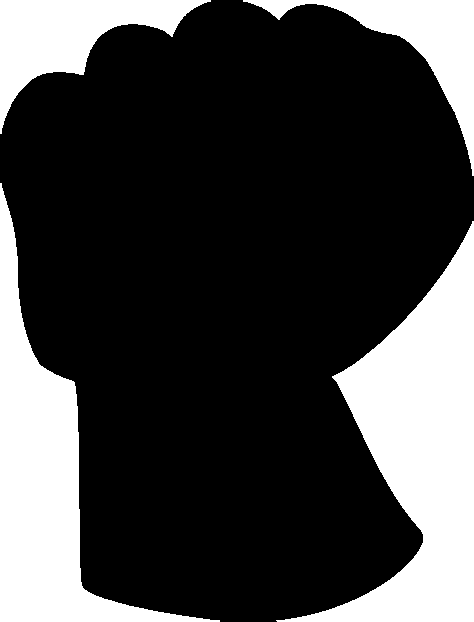

In [179]:
# create boot and fist masks
from PIL import Image
boot_mask = np.array(Image.open('/content/drive/Shareddrives/SIADS M2 Project/boot.png'))
fist_mask = np.array(Image.open('/content/drive/Shareddrives/SIADS M2 Project/fist.png'))
# boot_mask_show = Image.open('/content/drive/Shareddrives/SIADS M2 Project/boot.png')
# boot_mask_show
fist_mask_show = Image.open('/content/drive/Shareddrives/SIADS M2 Project/fist.png')
fist_mask_show

In [180]:
# check array values: should be 0, 255

boot_mask.min(), boot_mask.max(), fist_mask.min(), fist_mask.max()

(0, 1, 0, 1)

In [181]:
# change mask array values to 0, 255

def val_change(image_val):
  if image_val == 0:
    return 255
  else:
    return 0

for i in range(len(boot_mask)):
  boot_mask[i] = list(map(val_change, boot_mask[i]))

for i in range(len(fist_mask)):
  fist_mask[i] = list(map(val_change, fist_mask[i]))

In [182]:
# verify change to 0, 255

boot_mask.min(), boot_mask.max(), fist_mask.min(), fist_mask.max()

(0, 255, 0, 255)

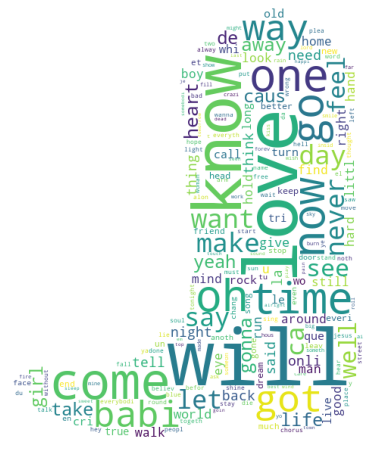

In [178]:
# generate country lyric wordcloud

country_wordcloud_image = WordCloud(collocations=False, background_color = 'white', stopwords=STOPWORDS, mask=boot_mask).generate(country_wordcloud)
plt.figure(figsize = (10, 8))
plt.imshow(country_wordcloud_image)
plt.axis("off")
plt.show();

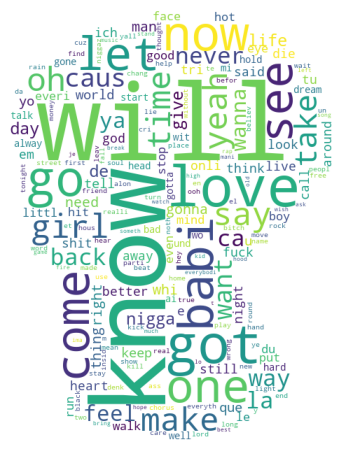

In [183]:
# generate hip hop lyric wordcloud

hip_hop_wordcloud_image = WordCloud(collocations=False, background_color = 'white', stopwords=STOPWORDS, mask=fist_mask).generate(hip_hop_wordcloud)
plt.figure(figsize = (10, 8))
plt.imshow(hip_hop_wordcloud_image)
plt.axis("off")
plt.show();

In [57]:
# method for TF-IDF and LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def tf_idf_LDA(df, stopwords, n_topics, n_top_words): #(e.g. tf_idf_LDA(hh_words, True, 10, 8))
  if stopwords == True:
    vectorizer = TfidfVectorizer(stop_words='english')
  else:
    vectorizer = TfidfVectorizer()
  tfidf_docs = vectorizer.fit_transform(df)
  tfidf_feature_names = vectorizer.get_feature_names_out()

  lda = LatentDirichletAllocation(n_components = n_topics, random_state = 0)
  lda.fit(tfidf_docs)
  topic_models = lda.components_
  
  # display topics
  for topic_idx, topic in enumerate(topic_models):
    term_list = [tfidf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Topic %d:" % (topic_idx), term_list)

In [58]:
# all songs without removing stopwords
tf_idf_LDA(all_genres_comb_words, False, 10, 8)

Topic 0: ['je', 'et', 'de', 'les', 'la', 'le', 'dan', 'qui']
Topic 1: ['woah', 'slave', 'tumbl', 'slap', 'jah', 'roller', 'mort', 'aye']
Topic 2: ['sunday', 'panic', 'ooo', 'perform', 'knot', 'digit', 'collid', 'explos']
Topic 3: ['the', 'you', 'to', 'and', 'it', 'not', 'me', 'my']
Topic 4: ['na', 'spoon', 'inch', 'saa', 'nyt', 'enchant', 'ei', 'scarlet']
Topic 5: ['saturday', 'itâ', 'bye', 'movin', 'nake', 'donâ', 'tour', 'losin']
Topic 6: ['gangsta', 'pig', 'himself', 'heartbreak', 'welcom', 'yearn', 'vultur', 'ar']
Topic 7: ['thi', 'och', 're', 'jag', 'neon', 'som', 'obey', 'det']
Topic 8: ['breakin', 'indian', 've', 'enter', 'templ', 'brutal', 'grate', 'term']
Topic 9: ['que', 'de', 'la', 'el', 'te', 'en', 'mi', 'tu']


In [59]:
# hip hop topics without removing stopwords
tf_idf_LDA(hip_hop_comb_words, False, 10, 8)

Topic 0: ['bye', 'christma', 'gimm', 'sono', 'borrow', 'brutal', 'tattoo', 'di']
Topic 1: ['the', 'you', 'and', 'to', 'it', 'not', 'my', 'me']
Topic 2: ['dem', 'slap', 'sha', 'gloria', 'pig', 'mi', 'needl', 'pleasur']
Topic 3: ['crimson', 'valley', 'american', 'du', 'crimin', 'aaah', 'product', 'ordinari']
Topic 4: ['más', 'northern', 'belief', 'enchant', 'balloon', 'logic', 'enter', 'familiar']
Topic 5: ['ich', 'und', 'du', 'das', 'ist', 'wie', 'der', 'nicht']
Topic 6: ['quarter', 'rescu', 'digit', 'coward', 'heartach', 'torment', 'hero', 'june']
Topic 7: ['et', 'la', 'de', 'le', 'je', 'dan', 'un', 'les']
Topic 8: ['que', 'la', 'de', 'te', 'tu', 'el', 'en', 'mi']
Topic 9: ['gangsta', 'movin', 'suicid', 'denk', 'hungri', 'polit', 'samba', 'unit']


In [60]:
# hip hop topics with removing stopwords
tf_idf_LDA(hip_hop_comb_words, True, 10, 8)

Topic 0: ['neon', 'hungri', 'smell', 'ohoh', 'saturday', 'crimin', 'enchant', 'hero']
Topic 1: ['ich', 'und', 'du', 'das', 'ist', 'wie', 'der', 'crimson']
Topic 2: ['anymor', 'bit', 'denk', 'bass', 'rip', 'quarter', 'ultim', 'galaxi']
Topic 3: ['tumbl', 'movin', 'prove', 'ay', 'ella', 'somewher', 'dreamin', 'warn']
Topic 4: ['que', 'tu', 'la', 'te', 'el', 'en', 'mi', 'es']
Topic 5: ['like', 'love', 'know', 'got', 'just', 'babi', 'come', 'time']
Topic 6: ['bye', 'suicid', 'pig', 'april', 'resist', 'goodnight', 'white', 'alcohol']
Topic 7: ['la', 'et', 'je', 'le', 'dan', 'les', 'des', 'qui']
Topic 8: ['slap', 'someday', 'cross', 'beneath', 'amaz', 'action', 'nah', 'gal']
Topic 9: ['ordinari', 'ven', 'pleasur', 'sail', 'unit', 'ocean', 'aaah', 'water']


In [61]:
# country topics without removing stopwords
tf_idf_LDA(country_comb_words, False, 10, 8)

Topic 0: ['de', 'la', 'et', 'les', 'un', 'le', 'je', 'des']
Topic 1: ['jame', 'saturday', 'satellit', 'juli', 'crimson', 'river', 'civil', 'john']
Topic 2: ['na', 'johnni', 'aye', 'seven', 'du', 'person', 'gimm', 'sung']
Topic 3: ['ya', 'cheer', 'whoa', 'woah', 'welcom', 'hell', 'between', 'yea']
Topic 4: ['river', 'rollin', 'thrill', 'queen', 'roller', 'lift', 'stood', 'beneath']
Topic 5: ['rise', 'sake', 'yea', 'lee', 'queda', 'total', 'hunter', 'freez']
Topic 6: ['you', 'the', 'and', 'to', 'it', 'me', 'not', 'my']
Topic 7: ['roll', 'christma', 'power', 'worship', 'between', 'sere', 'ser', 'prayer']
Topic 8: ['merri', 'class', 'linda', 'lou', 'di', 'christma', 'disappear', 'join']
Topic 9: ['que', 'en', 'mi', 'de', 'tu', 'te', 'el', 'yo']


In [62]:
# country topics with removing stopwords
tf_idf_LDA(country_comb_words, True, 10, 8)

Topic 0: ['love', 'know', 'come', 'like', 'just', 'time', 'babi', 'oh']
Topic 1: ['grace', 'saturday', 'hit', 'cover', 'total', 'pleasur', 'kill', 'hurtin']
Topic 2: ['jesus', 'everyon', 'lord', 'borrow', 'da', 'build', 'parad', 'beneath']
Topic 3: ['act', 'walkin', 'dead', 'lee', 'run', 'becom', 'ooo', 'hole']
Topic 4: ['second', 'parti', 'heavi', 'lift', 'woah', 'amaz', 'iron', 'blood']
Topic 5: ['run', 'na', 'ti', 'suicid', 'juli', 'jingl', 'don', 'queda']
Topic 6: ['que', 'la', 'et', 'en', 'tu', 'le', 'les', 'je']
Topic 7: ['fli', 'longer', 'run', 'em', 'whiskey', 'la', 'loser', 'crimson']
Topic 8: ['christma', 'run', 'taken', 'somebodi', 'kill', 'aye', 'jesus', 'lone']
Topic 9: ['caught', 'worth', 'imagin', 'johnni', 'wast', 'rave', 'maria', 'du']


In [63]:
# method for calculating word count per song

def word_counter(df, word):
  return round([item for sublist in df for item in sublist].count(word) / len(df), 2) # flatten list of lists then count word instance divided by song count

In [64]:
print("Country songs word count of 'you' and 'your' per song: " + str(word_counter(country_words, 'you') + word_counter(country_words, 'your')))
print("Country songs word count of 'me' and 'my' per song: " + str(word_counter(country_words, 'me') + word_counter(country_words, 'my')))
print("Hip hop songs word count of 'you' and 'your' per song: " + str(word_counter(hip_hop_words, 'you') + word_counter(hip_hop_words, 'your')))
print("Hip hop songs word count of 'me' and 'my' per song: " + str(word_counter(hip_hop_words, 'me') + word_counter(hip_hop_words, 'my')))

Country songs word count of 'you' and 'your' per song: 9.08
Country songs word count of 'me' and 'my' per song: 6.54
Hip hop songs word count of 'you' and 'your' per song: 12.719999999999999
Hip hop songs word count of 'me' and 'my' per song: 8.8


In [65]:
# proportionality of country versus hip hop of self-focused versus others-focused words
print(round(9.08/6.54,2), round(12.72/8.8,2))

1.39 1.45


In [66]:
# Flesch Kincaid exploration of lyric complexity between genres
!pip install fkscore
from fkscore import fkscore

def fk(df):
  return ([fkscore(x).score['readability'] for x in df])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
hh_fk_score = fk(hip_hop_comb_words)
c_fk_score = fk(country_comb_words)
print(hh_fk_score[:10])
print("FK score for hip hop: " + str(np.mean(hh_fk_score)), '\n', "FK score for country: " + str(np.mean(c_fk_score)))
print("Flesch Kincaid is not usable in this instance because the data came as a bag of words. \n \
Sentence length is a major factor in FK score and all songs appear to be one sentence long due to formatting. \n \
For this same reason we cannot do other analyses such as Word2Vec.")

[-53.912, -99.375, -224.039, 44.875, -22.995, -126.625, -581.672, -336.237, -439.447, -203.936]
FK score for hip hop: -200.54620512820512 
 FK score for country: -109.96492941176471
Flesch Kincaid is not usable in this instance because the data came as a bag of words. 
 Sentence length is a major factor in FK score and all songs appear to be one sentence long due to formatting. 
 For this same reason we cannot do other analyses such as Word2Vec.


---
## Supervised Learning
_sebcapp_

In [68]:
# # Import Modules
# from google.colab import drive
# import pandas as pd
# import numpy as np

# drive.mount('/content/drive')
# analysis_data = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/analysis_data.csv')
# country_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/country_df.csv')
# hip_hop_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/hip_hop_df.csv')
# rock_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/rock_df.csv')
# pop_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/pop_df.csv')
# jazz_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/jazz_df.csv')
# electronic_df = pd.read_csv('/content/drive/Shareddrives/SIADS M2 Project/electronic_df.csv')

In [69]:
# create df copies and input copies of dataframes into dictionary
analysis_data_SL = analysis_data.copy()
country_data_SL = country_df.copy()
hip_hop_df_SL = hip_hop_df.copy()
rock_df_SL = rock_df.copy()
pop_df_SL = pop_df.copy()
jazz_df_SL = jazz_df.copy()
electronic_df_SL = electronic_df.copy()
dfs = [analysis_data_SL, country_data_SL, hip_hop_df_SL, rock_df_SL, pop_df_SL, jazz_df_SL, electronic_df_SL]
dfs_dict = {'analysis_data_SL':analysis_data_SL, 'country_df_SL':country_data_SL, 'hip_hop_df_SL':hip_hop_df_SL, 'pop_df_SL':pop_df_SL,'jazz_df_SL':jazz_df_SL, 'electronic_df_SL':electronic_df_SL}

# set up random_state
seed = 0

## Data Cleaning and Preparation

In [70]:
# import modules
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xbg
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, auc
from sklearn import preprocessing


# MinMaxScaler - assumption that features on same scale
# StandardScaler - for standardizing
# RobustScaler - recommend for outliers


### Drop Unnecessary Data and Handle Missing Data

In [71]:
# Unnecessary feature removal
remove_features = ['Unnamed: 0', 'artist_7digitalid', 'track_7digitalid', 'release_7digitalid']
for df in dfs:
  remove_columns = set(df.columns).intersection(set(remove_features))
  df.drop(columns=remove_columns, inplace=True)

In [72]:
# Handle Missing Data

# list of features
features = list(analysis_data_SL.columns)

# get dataframe of null values across all dataframes by feature
def feature_null_df(feature_list, dfs_dictionary):
  result = pd.DataFrame(columns=['dataframe', 'proportion'])
  dataframes = list()
  proportions = list()
  missing_feature = list()

  for feature in feature_list:
    for df_name, df in dfs_dictionary.items():
      if df[feature].isnull().sum()>0:
        missing_feature.append(feature)
        dataframes.append(df_name)
        proportions.append(df[feature].isnull().sum()/df.shape[0])

  result['dataframe'] = dataframes
  result['feature'] = missing_feature
  result['proportion_missing'] = proportions
  return result

# create dataframe listing which dataframe, feature, and the proportion of that feature missing from df
null_df = feature_null_df(features, dfs_dict)

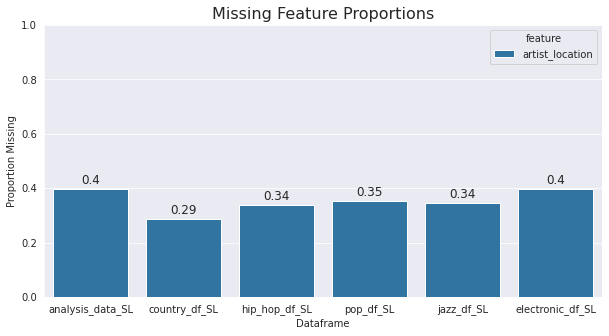

In [73]:
# Bar chart of proportion of missing from each feature by dataframe
sns.set_style("darkgrid")

plt.figure(figsize=(10,5))

bar1 = sns.barplot(data=null_df, x='dataframe',y='proportion_missing', hue='feature')
bar1.set_ylim(0,1)
plt.ylabel("Proportion Missing")
plt.xlabel("Dataframe")
plt.title('Missing Feature Proportions', fontsize=16)
for i in range(len(null_df.dataframe)):
  bar1.text(i, null_df['proportion_missing'][i]+0.02, str(round(null_df['proportion_missing'][i],2)),
            fontdict=dict(fontsize=12), horizontalalignment="center")


In [74]:
# drop artist_location feature, doesn't provide useful info and removal of observations based on missing artist_location value would remove too many
for df in dfs:
  if set(['artist_location']).issubset(df.columns):
    df.drop(columns=['artist_location'], inplace=True)

In [75]:
# review range of unique values for each feature
for col in analysis_data_SL.columns:
  print(f'Column {col.upper()} Unique Values: {len(analysis_data_SL[col].unique())}; dtype: {str(analysis_data_SL[col].dtype).upper()}')

# check idx_similar_artists, danceability, energy
analysis_data_SL[['file_name','idx_similar_artists','danceability','energy']].head(3)

Column FILE_NAME Unique Values: 5645; dtype: OBJECT
Column ARTIST_ID Unique Values: 2769; dtype: OBJECT
Column ARTIST_NAME Unique Values: 2994; dtype: OBJECT
Column ARTIST_HOTTTNESSS Unique Values: 2704; dtype: FLOAT64
Column RELEASE Unique Values: 4690; dtype: OBJECT
Column SONG_HOTTTNESSS Unique Values: 1919; dtype: FLOAT64
Column SONG_ID Unique Values: 5645; dtype: OBJECT
Column TITLE Unique Values: 5539; dtype: OBJECT
Column IDX_SIMILAR_ARTISTS Unique Values: 1; dtype: INT64
Column GENRE_TAGS Unique Values: 2755; dtype: OBJECT
Column DANCEABILITY Unique Values: 1; dtype: FLOAT64
Column DURATION Unique Values: 4333; dtype: FLOAT64
Column ENERGY Unique Values: 1; dtype: FLOAT64
Column KEY Unique Values: 12; dtype: INT64
Column LOUDNESS Unique Values: 4711; dtype: FLOAT64
Column MODE Unique Values: 2; dtype: INT64
Column TEMPO Unique Values: 5431; dtype: FLOAT64
Column BOOSTED_SCORE Unique Values: 1954; dtype: FLOAT64


,file_name,idx_similar_artists,danceability,energy
0,TRBGAWQ128F9305F25.h5,0,0.0,0.0
1,TRBGACK12903CD5CF5.h5,0,0.0,0.0
2,TRBGAVN128F424142C.h5,0,0.0,0.0


In [76]:
# drop check idx_similar_artists, danceability, energy
for df in dfs:
  if set(['idx_similar_artists','danceability','energy']).issubset(df.columns):
    df.drop(columns=['idx_similar_artists','danceability','energy'], inplace=True)

analysis_data_SL.columns

Index(['file_name', 'artist_id', 'artist_name', 'artist_hotttnesss', 'release',
       'song_hotttnesss', 'song_id', 'title', 'genre_tags', 'duration', 'key',
       'loudness', 'mode', 'tempo', 'boosted_score'],
      dtype='object')

## Distributions, Correlations, and Outliers

Text(0.5, 1.0, 'Quantitative Feature Correlation Heatmap')

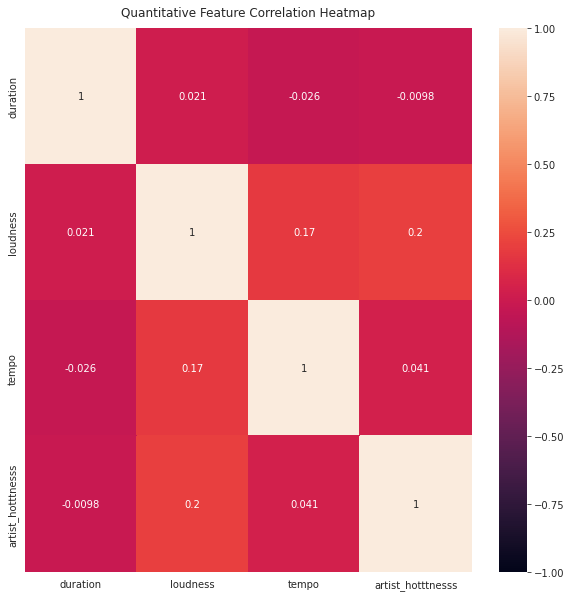

In [77]:
# specific features interested in for training
train_features_quant = ['duration','loudness','tempo','artist_hotttnesss']
train_features_cat = ['artist_id','release','title','genre_tags','key','mode']

# review features, check for multicollinearity
plt.figure(figsize=(10,10))
heatmap_corr = sns.heatmap(analysis_data_SL[train_features_quant].corr(), vmin=-1, vmax=1, annot=True)
heatmap_corr.set_title('Quantitative Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

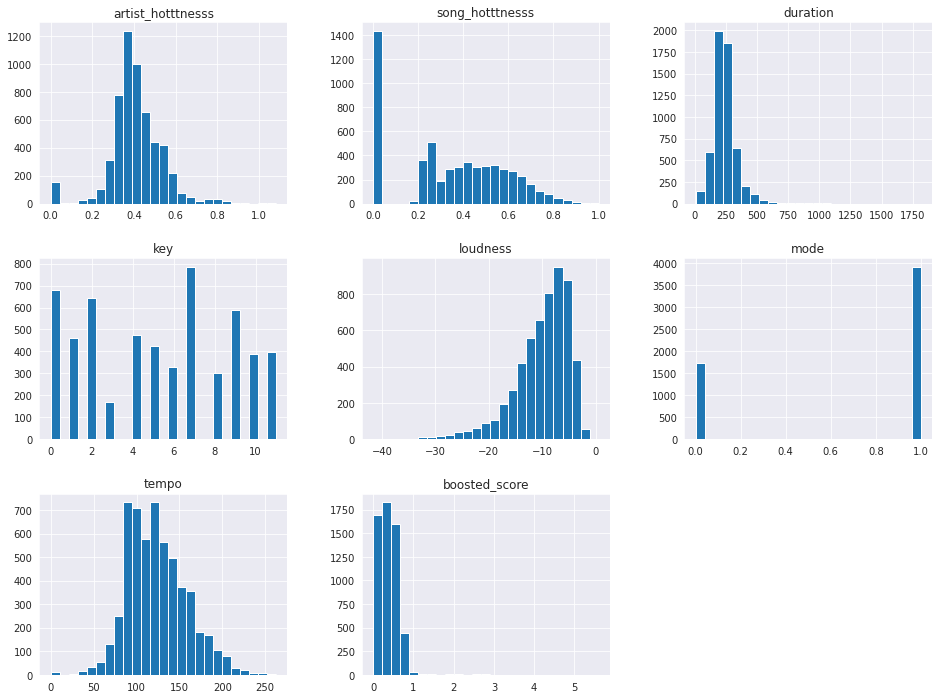

In [78]:
# check distributions and outliers
analysis_data_SL.hist(bins=25, figsize= (16,12))
plt.show()

In [79]:
# 74.65% of hotness scores > 0
print(f"% of Hotness Scores > 0: {len(analysis_data_SL[analysis_data_SL['song_hotttnesss']>0])/len(analysis_data_SL)}")

# 74.75% of boost_scores > 0
print(f"% of Boosted Scores > 0: {len(analysis_data_SL[analysis_data_SL['boosted_score']>0])/len(analysis_data_SL)}")


% of Hotness Scores > 0: 0.7465013286093889
% of Boosted Scores > 0: 0.7475642161204605


Text(0.5, 1.0, 'Correlation Target Variable')

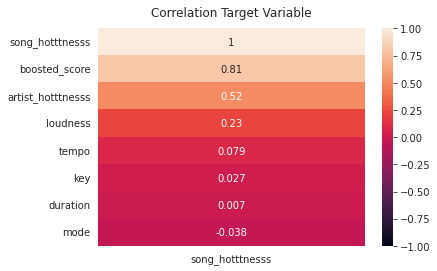

In [80]:
# see correlation across all song features, regardless of genre, and song_hotttness score
heatmap = sns.heatmap(analysis_data_SL.corr()[['song_hotttnesss']].sort_values(by='song_hotttnesss', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Target Variable', fontdict={'fontsize':12}, pad=12)

#ignore boost_score

In [81]:
# box and whisker plots of song features
fig = px.box(analysis_data_SL[['duration','loudness','tempo','artist_hotttnesss','song_hotttnesss','boosted_score']].melt(), y="value", facet_col="variable", boxmode="overlay", color="variable")
fig.update_yaxes(matches=None)

fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', showticklabels=False)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

fig.show()

In [82]:
# number of songs with boosted scores
print(f"Songs with boosted scores: {len(analysis_data_SL[analysis_data_SL['boosted_score']!=analysis_data_SL['song_hotttnesss']])}")

Songs with boosted scores: 95


In [83]:
# do not remove songs based on boosted score, as only 95 received increase, reason for outliers in boosted_score

In [84]:
# remove outliers based on IQR of features
def outlier_removal_IQR(df, features):
  for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    upper_lim = Q3+1.5*IQR
    lower_lim = Q1-1.5*IQR
    df = df[(df[feature]>=lower_lim) & (df[feature]<=upper_lim)]
  return df

In [85]:
# analysis data SL shape before removing outliers
analysis_data_SL.shape

(5645, 15)

In [86]:
# shape of analysis dataframe after removing duration, loudness, and tempo outliers
analysis_df_SL_clean = outlier_removal_IQR(analysis_data_SL, ['duration', 'loudness','tempo'])
analysis_df_SL_clean.shape

(5162, 15)

In [87]:
# updated box and whisker plot
fig = px.box(analysis_df_SL_clean[['duration','loudness','tempo','artist_hotttnesss','song_hotttnesss','boosted_score']].melt(), y="value", facet_col="variable", boxmode="overlay", color="variable")
fig.update_yaxes(matches=None)

fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', showticklabels=False)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

fig.show()

In [88]:
len(analysis_df_SL_clean[analysis_df_SL_clean['boosted_score']!=analysis_df_SL_clean['song_hotttnesss']])

95

In [89]:
# remove outliers from artist hotness scores
analysis_df_SL_clean = outlier_removal_IQR(analysis_df_SL_clean, ['artist_hotttnesss'])
analysis_df_SL_clean.shape

(4831, 15)

In [90]:
# number of songs with boosted scores
print(f"Songs with boosted scores: {len(analysis_df_SL_clean[analysis_df_SL_clean['boosted_score']!=analysis_df_SL_clean['song_hotttnesss']])}")

Songs with boosted scores: 79


In [91]:
# update whisker plot with artist hotness outliers removed
fig = px.box(analysis_df_SL_clean[['duration','loudness','tempo','artist_hotttnesss','song_hotttnesss','boosted_score']].melt(), y="value", facet_col="variable", boxmode="overlay", color="variable")
fig.update_yaxes(matches=None)

fig.update_layout(legend = dict(bgcolor = 'white'))
fig.update_layout(plot_bgcolor='white')

fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', showticklabels=False)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')

fig.show()

In [92]:
# review info of analysis df
analysis_df_SL_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4831 entries, 0 to 5644
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   file_name          4831 non-null   object 
 1   artist_id          4831 non-null   object 
 2   artist_name        4831 non-null   object 
 3   artist_hotttnesss  4831 non-null   float64
 4   release            4831 non-null   object 
 5   song_hotttnesss    4831 non-null   float64
 6   song_id            4831 non-null   object 
 7   title              4831 non-null   object 
 8   genre_tags         4831 non-null   object 
 9   duration           4831 non-null   float64
 10  key                4831 non-null   int64  
 11  loudness           4831 non-null   float64
 12  mode               4831 non-null   int64  
 13  tempo              4831 non-null   float64
 14  boosted_score      4831 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 603.9+ KB


In [93]:
# recreate hip hop and country dataframes based on data with removed outliers
hip_hop_df_SL_clean = analysis_df_SL_clean[analysis_df_SL_clean['genre_tags'].str.contains('hip hop')]
country_df_SL_clean = analysis_df_SL_clean[analysis_df_SL_clean['genre_tags'].str.contains('country')]

print(f"Percent removed observations from hip hop song data: {round(((hip_hop_df_SL.shape[0]-hip_hop_df_SL_clean.shape[0])/hip_hop_df_SL.shape[0]), 3)*100}")
print(f"Percent removed observations from hip hop song data: {round(((country_data_SL.shape[0]-country_df_SL_clean.shape[0])/country_data_SL.shape[0]), 3)*100}")

Percent removed observations from hip hop song data: 10.5
Percent removed observations from hip hop song data: 13.100000000000001


In [94]:
# analysis data top 5 rows
analysis_df_SL_clean.head(5)

,file_name,artist_id,artist_name,artist_hotttnesss,release,song_hotttnesss,song_id,title,genre_tags,duration,key,loudness,mode,tempo,boosted_score
0,TRBGAWQ128F9305F25.h5,ARYXOV81187B99831D,Seventh Day Slumber,0.509243,Take Everything,0.635630,SOPBEBP12AB0181527,Famous One,"christian rock, christian alternative rock, ch...",265.82159,5,-5.742,1,118.620,0.635630
2,TRBGAVN128F424142C.h5,ARD0FN11187B9B25CD,Bobby Darin,0.469426,Things & Other Things,0.382935,SOGOLHP12A8AE47A0D,"Theme From ""Come September"" (LP Version)","brill building pop, folk rock, folk-pop, vocal...",155.63710,0,-15.437,1,108.462,0.382935
3,TRBGAXJ12903CB10B1.h5,ARSRCI71187FB59188,David Rose & His Orchestra,0.305025,In A Mellow Mood,0.000000,SOWBDLD12A58A80B1A,One Love,"orchestra, space age pop, easy listening, jazz...",179.98322,10,-16.877,1,84.688,0.000000
4,TRBGGBF128F425E4D1.h5,AR7IYVY1187B9A2648,bel canto,0.368252,Magic Box,0.345802,SOBEHXG12A8C138D22,Rumour (Abstract Hip Hop Mix),"trip hop, downtempo, electronic, alternative d...",78.49751,7,-17.795,1,106.936,0.345802
5,TRBGGYE128F42B63AB.h5,ARWV0Q11187FB4CDCE,Arc Angels,0.349366,Arc Angels,0.473347,SOAPTWU12A8C1409CB,See What Tomorrow Brings,"blues-rock, southern rock, hard rock, slide, b...",386.79465,8,-10.118,1,125.787,0.473347


In [95]:
# sort dataframes by boosted_score
analysis_df_SL_clean = analysis_df_SL_clean.sort_values(by=['boosted_score','song_hotttnesss'], ascending=False)
country_df_SL_clean = country_df_SL_clean.sort_values(by=['boosted_score','song_hotttnesss'], ascending=False)
country_df_SL_clean = country_df_SL_clean.sort_values(by=['boosted_score','song_hotttnesss'], ascending=False)

analysis_df_SL_clean.head(5)

,file_name,artist_id,artist_name,artist_hotttnesss,release,song_hotttnesss,song_id,title,genre_tags,duration,key,loudness,mode,tempo,boosted_score
1113,TRBDWDQ128F1455787.h5,ARW1MUW1187FB4D5A1,3 Doors Down,0.608849,Seventeen Days,0.704520,SOUEHCD12AB0188F80,Here Without You,"post-grunge, alternative metal, heavy metal, r...",232.07138,10,-6.348,0,143.699,5.600520
3480,TRAMFJR128F92C1DB1.h5,ARAEX7Y1187FB42D36,Toni Braxton,0.555969,The Essential Toni Braxton,0.796349,SOQCQNU12A8C138694,He Wasn't Man Enough,"dance pop, rock, urban, adult contemporary, cl...",262.08608,11,-3.825,0,175.959,4.459349
4590,TRAXLZU12903D05F94.h5,ARWPYQI1187FB4D55A,Rick Astley,0.507464,Big Tunes - Back 2 The 80s,0.864249,SOCWJDB12A58A776AF,Never Gonna Give You Up,"dance pop, rock, pop, england, adult contempor...",211.69587,1,-7.750,1,113.359,3.264249
2170,TRAAIHL128F92E6DDA.h5,ARR9XGB1187B9912E6,Boyz II Men,0.601185,Legacy,0.345802,SOFRAZJ12A8C143CDB,On Bended Knee,"new jack swing, urban, soul, adult contemporar...",329.27302,8,-7.103,1,116.473,3.045802
3094,TRAEMNZ128F9334662.h5,AR12F2S1187FB56EEF,Aerosmith,0.610731,A Little South Of Sanity,0.415050,SOGVJTG12A6701E991,Angel,"blues-rock, heavy metal, hard rock, pop rock, ...",335.33342,2,-5.763,1,76.096,2.865050


In [96]:
# scale data, went with robust scaler due to outliers
rob_scaler = RobustScaler()

analysis_data_SL_scaled = analysis_df_SL_clean.copy()
country_df_SL_scaled = country_df_SL_clean.copy()
hip_hop_df_SL_scaled = hip_hop_df_SL_clean.copy()

analysis_data_SL_scaled[['tempo', 'duration', 'loudness']] = rob_scaler.fit_transform(analysis_data_SL_scaled[['tempo', 'duration', 'loudness']])
country_df_SL_scaled[['tempo', 'duration', 'loudness']] = rob_scaler.fit_transform(country_df_SL_scaled[['tempo', 'duration', 'loudness']])
hip_hop_df_SL_scaled[['tempo', 'duration', 'loudness']] = rob_scaler.fit_transform(hip_hop_df_SL_scaled[['tempo', 'duration', 'loudness']])

analysis_data_SL_scaled.head(5)

,file_name,artist_id,artist_name,artist_hotttnesss,release,song_hotttnesss,song_id,title,genre_tags,duration,key,loudness,mode,tempo,boosted_score
1113,TRBDWDQ128F1455787.h5,ARW1MUW1187FB4D5A1,3 Doors Down,0.608849,Seventeen Days,0.704520,SOUEHCD12AB0188F80,Here Without You,"post-grunge, alternative metal, heavy metal, r...",0.085286,10,0.392848,0,0.486333,5.600520
3480,TRAMFJR128F92C1DB1.h5,ARAEX7Y1187FB42D36,Toni Braxton,0.555969,The Essential Toni Braxton,0.796349,SOQCQNU12A8C138694,He Wasn't Man Enough,"dance pop, rock, urban, adult contemporary, cl...",0.419735,11,0.818419,0,1.152848,4.459349
4590,TRAXLZU12903D05F94.h5,ARWPYQI1187FB4D55A,Rick Astley,0.507464,Big Tunes - Back 2 The 80s,0.864249,SOCWJDB12A58A776AF,Never Gonna Give You Up,"dance pop, rock, pop, england, adult contempor...",-0.141755,1,0.156363,1,-0.140514,3.264249
2170,TRAAIHL128F92E6DDA.h5,ARR9XGB1187B9912E6,Boyz II Men,0.601185,Legacy,0.345802,SOFRAZJ12A8C143CDB,On Bended Knee,"new jack swing, urban, soul, adult contemporar...",1.168389,8,0.265497,1,-0.076176,3.045802
3094,TRAEMNZ128F9334662.h5,AR12F2S1187FB56EEF,Aerosmith,0.610731,A Little South Of Sanity,0.415050,SOGVJTG12A6701E991,Angel,"blues-rock, heavy metal, hard rock, pop rock, ...",1.235919,2,0.491524,1,-0.910394,2.865050
